# Capstone – Emotionality of Tweets: BiLSTM Baseline

Notebook advisories

This notebook was developed with conceptual and implementation influence from Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow, and the Kaggle notebook “BiLSTM for text classification” by Shay Lapid.

AI Usage: AI assistance was used to help debug code, refine explanations, and assist comprehension of reinforcement learning concepts.

In [1]:
import random
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from pathlib import Path
from typing import List, Dict, Tuple
from collections import Counter
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    f1_score,
)

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data_utils import load_and_prepare_emotion_splits  # noqa: E402

PROJECT_ROOT

PosixPath('/Users/maine/School/Machine Learning 2/Final_Project_Code')

## 1. Configuration

In [2]:
# Configuration

DATA_DIR = PROJECT_ROOT / "data" / "primary_emotions"
print("Data directory:", DATA_DIR)

EMOTION_ID2NAME = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise",
}

# Model / training hyperparameters
MAX_SEQ_LEN = 64
MIN_FREQ = 1
EMBED_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 1
DROPOUT = 0.3
BATCH_SIZE = 64
NUM_EPOCHS = 8
LEARNING_RATE = 1e-3
RANDOM_STATE = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Data directory: /Users/maine/School/Machine Learning 2/Final_Project_Code/data/primary_emotions
Using device: cpu


## 2. Reproducibility

In [3]:
# Reproducibility

def set_seed(seed: int) -> None:
    """
    Set random seeds for reproducible experiments.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(RANDOM_STATE)

## 3. Tokenization and Vocabulary

In [4]:
# Tokenization and vocab

def tokenize(text: str) -> List[str]:
    """
    Very simple whitespace tokenizer.
    """
    return text.split()


def build_vocab(
        texts: List[str],
        min_freq: int = 1,
) -> Tuple[Dict[str, int], Dict[int, str]]:
    """
    Build a token -> id vocabulary from training texts.
    And Returns the reverse mapping id -> token.
    """

    counter = Counter()
    for t in texts:
        tokens = tokenize(t)
        counter.update(tokens)

    # Special tokens
    PAD_TOKEN = "<pad>"
    UNK_TOKEN = "<unk>"

    token2id = {
        PAD_TOKEN: 0,
        UNK_TOKEN: 1,
    }
    id2token = {
        0: PAD_TOKEN,
        1: UNK_TOKEN,
    }

    # Add tokens meeting min_freq
    for token, freq in counter.items():
        if freq >= min_freq:
            idx = len(token2id)
            token2id[token] = idx
            id2token[idx] = token

    return token2id, id2token


def encode_text(
        text: str,
        token2id: Dict[str, int],
        max_len: int,
) -> List[int]:
    """
    Convert a text string into a fixed-length sequence of token ids.
    Then returns the list of token ids.
    """
    tokens = tokenize(text)
    ids = [token2id.get(tok, token2id["<unk>"]) for tok in tokens]

    # Truncate
    ids = ids[:max_len]

    # Pad
    if len(ids) < max_len:
        ids = ids + [token2id["<pad>"]] * (max_len - len(ids))

    return ids

## 4. Dataset and DataLoader

In [5]:
# Dataset & DataLoader

class EmotionDataset(Dataset):
    def __init__(
            self,
            texts: List[str],
            labels: List[int],
            token2id: Dict[str, int],
            max_len: int,
    ) -> None:
        self.texts = texts
        self.labels = labels
        self.token2id = token2id
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int):
        text = self.texts[idx]
        label = self.labels[idx]
        ids = encode_text(text, self.token2id, self.max_len)
        length = min(len(tokenize(text)), self.max_len)

        return (
            torch.tensor(ids, dtype=torch.long),
            torch.tensor(length, dtype=torch.long),
            torch.tensor(label, dtype=torch.long),
        )


def collate_fn(batch):
    """
    Collate function for DataLoader.
    And returns batched tensors.
    """
    ids, lengths, labels = zip(*batch)
    ids = torch.stack(ids, dim=0)       # (batch, seq_len)
    lengths = torch.stack(lengths, dim=0)
    labels = torch.stack(labels, dim=0)
    return ids, lengths, labels

## 5. Bidirectional LSTM Model

In [6]:
# Bidirectional LSTM model

class LSTMClassifier(nn.Module):
    def __init__(
            self,
            vocab_size: int,
            embed_dim: int,
            hidden_dim: int,
            num_layers: int,
            num_classes: int,
            dropout: float,
            pad_idx: int,
            bidirectional: bool = True,
    ) -> None:
        super().__init__()

        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx,
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional,
        )

        self.dropout = nn.Dropout(dropout)
        # hidden_dim * num_directions goes into the classifier
        self.fc = nn.Linear(hidden_dim * self.num_directions, num_classes)

    def forward(self, input_ids, lengths):
        """
        Forward pass of the model.
        """
        embedded = self.embedding(input_ids)  # (batch, seq_len, embed_dim)
        lstm_out, (h_n, c_n) = self.lstm(embedded)
        # h_n shape: (num_layers * num_directions, batch, hidden_dim)

        if self.num_directions == 1:
            last_hidden = h_n[-1]  # (batch, hidden_dim)
        else:
            forward_hidden = h_n[-2]   # (batch, hidden_dim)
            backward_hidden = h_n[-1]  # (batch, hidden_dim)
            last_hidden = torch.cat((forward_hidden, backward_hidden), dim=1)

        out = self.dropout(last_hidden)
        logits = self.fc(out)  # (batch, num_classes)
        return logits

## 6. Evaluation Helpers

In [7]:
# Evaluation helper (same style as TF-IDF baseline)

def evaluate_predictions(
        y_true: List[int],
        y_pred: List[int],
        label_ids: List[int],
        label_names: List[str],
        split_name: str,
) -> None:
    """
    Print classification metrics and confusion matrix for a given split.
    """
    acc = accuracy_score(y_true, y_pred)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="macro",
        zero_division=0,
    )

    print(f"\n=== {split_name} Metrics ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Macro P:   {precision_macro:.4f}")
    print(f"Macro R:   {recall_macro:.4f}")
    print(f"Macro F1:  {f1_macro:.4f}")

    print("\nPer-class report:")
    print(
        classification_report(
            y_true,
            y_pred,
            labels=label_ids,
            target_names=label_names,
            zero_division=0,
        )
    )

    cm = confusion_matrix(y_true, y_pred, labels=label_ids)
    print("Confusion matrix (rows = true, cols = pred):")
    print(cm)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(label_names)),
        yticks=np.arange(len(label_names)),
        xticklabels=label_names,
        yticklabels=label_names,
        ylabel="True label",
        xlabel="Predicted label",
        title=f"{split_name} Confusion Matrix",
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    plt.show()


def compute_macro_f1_for_loader(
        model: nn.Module,
        data_loader: DataLoader,
        device: torch.device,
) -> float:
    """
    Compute macro-F1 for all examples in a DataLoader.
    """
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for input_ids, lengths, labels in data_loader:
            input_ids = input_ids.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)

            logits = model(input_ids, lengths)
            preds = torch.argmax(logits, dim=1)

            all_true.extend(labels.cpu().tolist())
            all_pred.extend(preds.cpu().tolist())

    return f1_score(all_true, all_pred, average="macro", zero_division=0)

## 7. Training Loop

In [8]:
# Training loop

def train_lstm_baseline() -> None:
    # 7.1 Load data
    splits = load_and_prepare_emotion_splits(DATA_DIR, normalize=True)
    X_train, y_train = splits.train_texts, splits.train_labels
    X_val, y_val = splits.val_texts, splits.val_labels
    X_test, y_test = splits.test_texts, splits.test_labels

    label_ids = sorted(EMOTION_ID2NAME.keys())
    label_names = [EMOTION_ID2NAME[i] for i in label_ids]

    print("Using emotion mapping:")
    print(EMOTION_ID2NAME)

    # 7.2 Vocab from training texts only
    token2id, id2token = build_vocab(X_train, min_freq=MIN_FREQ)
    vocab_size = len(token2id)
    pad_idx = token2id["<pad>"]

    print(f"Vocab size: {vocab_size}")

    # 7.3 Datasets & loaders
    train_dataset = EmotionDataset(X_train, y_train, token2id, MAX_SEQ_LEN)
    val_dataset = EmotionDataset(X_val, y_val, token2id, MAX_SEQ_LEN)
    test_dataset = EmotionDataset(X_test, y_test, token2id, MAX_SEQ_LEN)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
    )

    # 7.4 Model, optimizer, loss
    num_classes = len(label_ids)
    model = LSTMClassifier(
        vocab_size=vocab_size,
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        num_classes=num_classes,
        dropout=DROPOUT,
        pad_idx=pad_idx,
        bidirectional=True,
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = -1.0
    best_state = None

    # 7.5 Training loop
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        total_loss = 0.0

        for input_ids, lengths, labels in train_loader:
            input_ids = input_ids.to(DEVICE)
            lengths = lengths.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            logits = model(input_ids, lengths)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * input_ids.size(0)

        avg_train_loss = total_loss / len(train_dataset)

        # Compute validation macro-F1 for model selection
        val_macro_f1 = compute_macro_f1_for_loader(model, val_loader, DEVICE)

        print(
            f"Epoch {epoch}/{NUM_EPOCHS} "
            f"- Train loss: {avg_train_loss:.4f} "
            f"- Val Macro-F1: {val_macro_f1:.4f}"
        )

        if val_macro_f1 > best_val_f1:
            best_val_f1 = val_macro_f1
            best_state = model.state_dict()

    # 7.6 Load best state (by validation macro-F1)
    if best_state is not None:
        model.load_state_dict(best_state)

    # 7.7 Final evaluation on validation and test
    def collect_predictions(loader: DataLoader) -> Tuple[List[int], List[int]]:
        model.eval()
        all_true, all_pred = [], []
        with torch.no_grad():
            for input_ids, lengths, labels in loader:
                input_ids = input_ids.to(DEVICE)
                lengths = lengths.to(DEVICE)
                labels = labels.to(DEVICE)

                logits = model(input_ids, lengths)
                preds = torch.argmax(logits, dim=1)

                all_true.extend(labels.cpu().tolist())
                all_pred.extend(preds.cpu().tolist())
        return all_true, all_pred

    print("\nEvaluating on validation set...")
    y_val_true, y_val_pred = collect_predictions(val_loader)
    evaluate_predictions(y_val_true, y_val_pred, label_ids, label_names, "Validation")

    print("\nEvaluating on test set...")
    y_test_true, y_test_pred = collect_predictions(test_loader)
    evaluate_predictions(y_test_true, y_test_pred, label_ids, label_names, "Test")

## 8. Run Training

Using emotion mapping:
{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
Vocab size: 15214
Epoch 1/8 - Train loss: 1.5283 - Val Macro-F1: 0.2207
Epoch 2/8 - Train loss: 1.0577 - Val Macro-F1: 0.4793
Epoch 3/8 - Train loss: 0.6735 - Val Macro-F1: 0.7152
Epoch 4/8 - Train loss: 0.4159 - Val Macro-F1: 0.7738
Epoch 5/8 - Train loss: 0.2895 - Val Macro-F1: 0.8196
Epoch 6/8 - Train loss: 0.2050 - Val Macro-F1: 0.8165
Epoch 7/8 - Train loss: 0.1576 - Val Macro-F1: 0.8288
Epoch 8/8 - Train loss: 0.1190 - Val Macro-F1: 0.8295

Evaluating on validation set...

=== Validation Metrics ===
Accuracy:  0.8675
Macro P:   0.8319
Macro R:   0.8298
Macro F1:  0.8295

Per-class report:
              precision    recall  f1-score   support

     sadness       0.88      0.92      0.90       550
         joy       0.91      0.89      0.90       704
        love       0.78      0.68      0.73       178
       anger       0.89      0.84      0.86       275
        fear       0.77      0

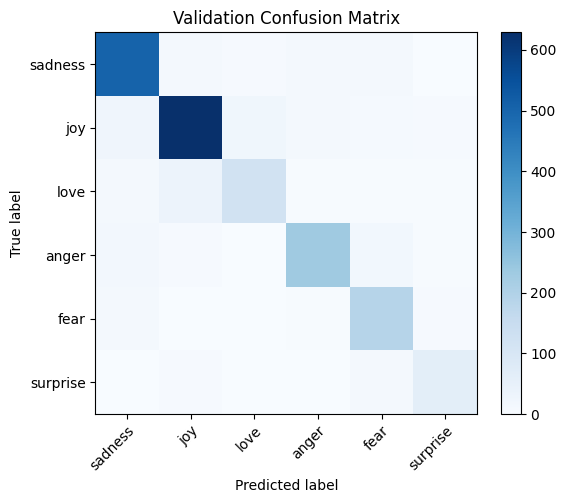


Evaluating on test set...

=== Test Metrics ===
Accuracy:  0.8650
Macro P:   0.8045
Macro R:   0.8087
Macro F1:  0.8049

Per-class report:
              precision    recall  f1-score   support

     sadness       0.91      0.92      0.91       581
         joy       0.91      0.91      0.91       695
        love       0.73      0.61      0.66       159
       anger       0.85      0.83      0.84       275
        fear       0.78      0.86      0.82       224
    surprise       0.64      0.73      0.68        66

    accuracy                           0.86      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.87      0.86      0.86      2000

Confusion matrix (rows = true, cols = pred):
[[536  12   3  15  14   1]
 [ 17 629  30   9   3   7]
 [  9  38  97   6   5   4]
 [ 19   8   2 227  19   0]
 [ 10   1   0   5 193  15]
 [  1   0   1   4  12  48]]


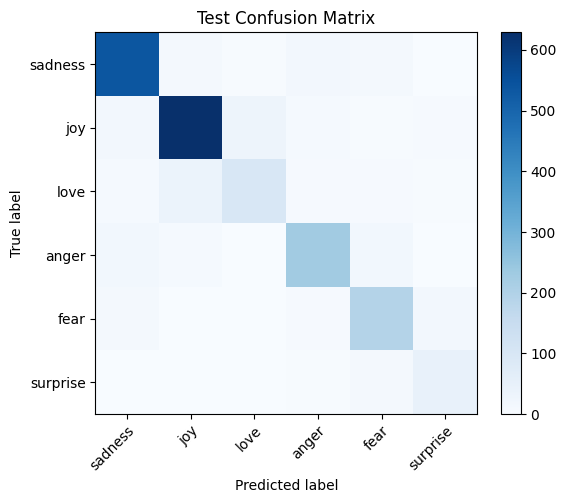

In [9]:
train_lstm_baseline()

## 9. Discussion and Conclusion

This notebook implemented a BiLSTM-based baseline for six-way emotion classification on tweets. Each tweet was encoded as a fixed-length sequence of token IDs, embedded into dense vectors, and passed through a single-layer bidirectional LSTM. The final forward and backward hidden states were concatenated, regularized with dropout, and fed into a linear classifier.

Trained with Adam and cross-entropy loss on the same train/validation/test splits as the TF–IDF + Logistic Regression model, the BiLSTM achieved higher overall accuracy (86%) and macro-F1(80%). This indicates that modeling word order and local context of the BiLSTM is better than treating tweets as an unordered collection like in the tfidf_logreg.

The results showed that the BiLSTM still struggles with the more subtle or rare emotions, and that its gains are incremental compared to the step up from a purely linear baseline. The model also has a higher training cost and is less interpretable than a linear classifier on TF–IDF features. Overall, this BiLSTM serves as a useful neural, non-transformer baseline.